In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define directories
dates_dir = '/arc/project/st-ashapi01-1/RADD'
rds_dir = '/scratch/st-ashapi01-1/rds_files/data_2024nps-db'
db_dir = '/arc/project/st-ashapi01-1/RADD_libraries'

In [58]:
ms1 = pd.read_csv(os.path.join(rds_dir, 'ms1/ms1.out'))
# Fragments
ms1 = ms1.iloc[:34618]
ms2 = pd.read_csv(os.path.join(rds_dir, 'ms2/ms2.out'))
ms2 = ms2.iloc[:561019]

/tmp/ipykernel_603902/2326074700.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  ms2 = pd.read_csv(os.path.join(rds_dir, 'ms2/ms2.out'))


In [59]:
ms1.drop(columns=['spectrum'], inplace=True)

In [61]:
ms2.columns.to_list()

['filename', 'compound_name', 'spectrum', 'm.z', 'mz', 'i']

In [62]:
# Read databases
db1 = pd.read_csv(os.path.join(db_dir, 'NPS_DB-240705.csv'), index_col=False, skiprows=5)
# Remove columns with a single unique value
keep = db1.apply(lambda col: col.nunique() > 1)
db1 = db1.loc[:, keep]

databases = {"NPS": db1}

# Function to calculate PPM range
def calc_ppm_range(theor_mass, err_ppm=10):
    theor_mass = float(theor_mass)  # Ensure theor_mass is float
    lower_bound = (-err_ppm / 1e6 * theor_mass) + theor_mass
    upper_bound = (err_ppm / 1e6 * theor_mass) + theor_mass
    return lower_bound, upper_bound

# Calculate evidence for each peak
def calculate_matches(row):
    lower_bound, upper_bound = calc_ppm_range(row['Product m/z'], err_ppm=20)
    return lower_bound <= row['mz'] <= upper_bound

# Filter fragments and drop duplicates
fragments = db1[db1['Workflow'] == 'Fragment'].drop_duplicates(subset=['Compound Name', 'Product m/z'])

# Calculate evidence for each peak
evidence_per_fragment = ms2.merge(fragments, left_on='compound_name', right_on='Compound Name', how='left')
evidence_per_fragment['match'] = evidence_per_fragment.apply(calculate_matches, axis=1)

# Ensure 'm/z' is included for grouping
evidence_per_fragment = evidence_per_fragment[['filename', 'compound_name', 'spectrum', 'mz', 'Product m/z', 'Retention Time', 'match']]
evidence_per_fragment_original = evidence_per_fragment.copy()
# Group by file, compound, spectrum, and m/z
evidence_per_fragment = (
    evidence_per_fragment
    .groupby(['filename', 'compound_name', 'spectrum', 'mz'])
    .agg(
        match=('match', 'sum'),
        product_mz=('Product m/z', 'first'),
        db_rt=('Retention Time', 'first')  # or use lambda x: x.iloc[0]
    )
    .reset_index()
)

evidence_per_fragment = evidence_per_fragment.reset_index()
# Aggregate evidence per parent
evidence_per_parent = (evidence_per_fragment
                       .groupby(['filename', 'compound_name', 'spectrum'])
                       .agg(matches=('match', 'sum'),
                       db_rt=('db_rt', 'first'))
                       ).reset_index()

# Calculate total fragments
total_fragments = fragments.groupby('Compound Name').size().reset_index(name='total_fragments')

# Merge total_fragments into evidence_per_parent
evidence_per_parent = evidence_per_parent.merge(total_fragments, left_on='compound_name', right_on='Compound Name', how='left')

# Merge with ms1 (including m/z)
ms1 = ms1.merge(evidence_per_parent, on=["filename", "compound_name"], how="left")

# Modify this back to m.z and mz
ms1["mz"] = ms1["mz"].astype(float)
ms1["m.z"] = ms1["m.z"].astype(float)
# Tag ppm error
# mass that was found in the sample compared to precursor ion in the database

# Modify this back to m.z and mz
ms1["ppm_err"] = 1e6 * (ms1["mz"] - ms1["m.z"]) / ms1["m.z"]

In [63]:
ms1.columns.to_list()

['filename',
 'compound_name',
 'Retention.Time',
 'Retension.TimeWindow',
 'm.z',
 'mz',
 'rt',
 'intens',
 'spectrum',
 'matches',
 'db_rt',
 'Compound Name',
 'total_fragments',
 'ppm_err']

In [64]:
# Keep only best evidence per file
best = ms1.sort_values(by=["matches"], ascending=False).groupby(["filename", "compound_name"]).head(1).reset_index(drop=True)
best2 = best[best["matches"] >= 2]

# Calculate proportion of reference product ions detected
best2.loc[:, "prop_reference_ions"] = best2["matches"] / best2["total_fragments"]



/tmp/ipykernel_603902/2775149391.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best2.loc[:, "prop_reference_ions"] = best2["matches"] / best2["total_fragments"]


In [65]:
best2.head()

,filename,compound_name,Retention.Time,Retension.TimeWindow,m.z,mz,rt,intens,spectrum,matches,db_rt,Compound Name,total_fragments,ppm_err,prop_reference_ions
0,2023-2213BG01,Eutylone,NaN,30,236.12812,236.127695,245.673444,3.915749e+06,CP2685.F1.S2959,7,NaN,Eutylone,9,-1.801366,0.777778
1,2024-2266BG01,4'-Cl-deschloroalprazolam,NaN,30,309.09015,309.089996,366.224718,5.001769e+05,CP4600.F1.S4558,6,NaN,4'-Cl-deschloroalprazolam,6,-0.497143,1.000000
2,2023-4588BG01,4'-Cl-deschloroalprazolam,NaN,30,309.09015,309.089539,371.941008,3.206217e+06,CP4230.F1.S4448,6,NaN,4'-Cl-deschloroalprazolam,6,-1.978147,1.000000
3,2023-1175BG01,4'-Cl-deschloroalprazolam,NaN,30,309.09015,309.089752,381.255216,4.291084e+05,CP4485.F1.S4842,6,NaN,4'-Cl-deschloroalprazolam,6,-1.287012,1.000000
4,2024-1573BG01,4'-Cl-deschloroalprazolam,NaN,30,309.09015,309.090179,369.809970,4.704544e+06,CP3545.F1.S4409,6,NaN,4'-Cl-deschloroalprazolam,6,0.095258,1.000000


In [66]:
best2['prop_reference_ions'].value_counts()

prop_reference_ions
1.000000    2444
0.800000     507
0.285714     338
0.500000     336
0.400000     323
0.750000     274
0.600000     205
0.666667      76
0.222222      52
0.333333      35
0.428571      26
0.833333       4
0.777778       1
0.714286       1
0.444444       1
Name: count, dtype: int64

In [67]:
best2.head()

,filename,compound_name,Retention.Time,Retension.TimeWindow,m.z,mz,rt,intens,spectrum,matches,db_rt,Compound Name,total_fragments,ppm_err,prop_reference_ions
0,2023-2213BG01,Eutylone,NaN,30,236.12812,236.127695,245.673444,3.915749e+06,CP2685.F1.S2959,7,NaN,Eutylone,9,-1.801366,0.777778
1,2024-2266BG01,4'-Cl-deschloroalprazolam,NaN,30,309.09015,309.089996,366.224718,5.001769e+05,CP4600.F1.S4558,6,NaN,4'-Cl-deschloroalprazolam,6,-0.497143,1.000000
2,2023-4588BG01,4'-Cl-deschloroalprazolam,NaN,30,309.09015,309.089539,371.941008,3.206217e+06,CP4230.F1.S4448,6,NaN,4'-Cl-deschloroalprazolam,6,-1.978147,1.000000
3,2023-1175BG01,4'-Cl-deschloroalprazolam,NaN,30,309.09015,309.089752,381.255216,4.291084e+05,CP4485.F1.S4842,6,NaN,4'-Cl-deschloroalprazolam,6,-1.287012,1.000000
4,2024-1573BG01,4'-Cl-deschloroalprazolam,NaN,30,309.09015,309.090179,369.809970,4.704544e+06,CP3545.F1.S4409,6,NaN,4'-Cl-deschloroalprazolam,6,0.095258,1.000000


In [68]:
# Prepare data
best2['pct'] = round(100 * best2['matches'] / best2['total_fragments'])
best2['pct_cut'] = pd.cut(best2['matches'] / (best2['total_fragments']+1e-10), 5)
# Set up color palettes
pal1 = ['#e0e0e0', '#1f78b4', '#33a02c', '#fb9a99', '#e31a1c']  # Example colors
pal2 = sns.cubehelix_palette(100, start=2, rot=0, dark=0.3, light=0.7)



/tmp/ipykernel_603902/335392688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best2['pct'] = round(100 * best2['matches'] / best2['total_fragments'])
/tmp/ipykernel_603902/335392688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best2['pct_cut'] = pd.cut(best2['matches'] / (best2['total_fragments']+1e-10), 5)


In [69]:
best2['pct_cut']

0       (0.689, 0.844]
1         (0.844, 1.0]
2         (0.844, 1.0]
3         (0.844, 1.0]
4         (0.844, 1.0]
             ...      
4618    (0.378, 0.533]
4619    (0.378, 0.533]
4620    (0.378, 0.533]
4621    (0.533, 0.689]
4622    (0.378, 0.533]
Name: pct_cut, Length: 4623, dtype: category
Categories (5, interval[float64, right]): [(0.221, 0.378] < (0.378, 0.533] < (0.533, 0.689] < (0.689, 0.844] < (0.844, 1.0]]

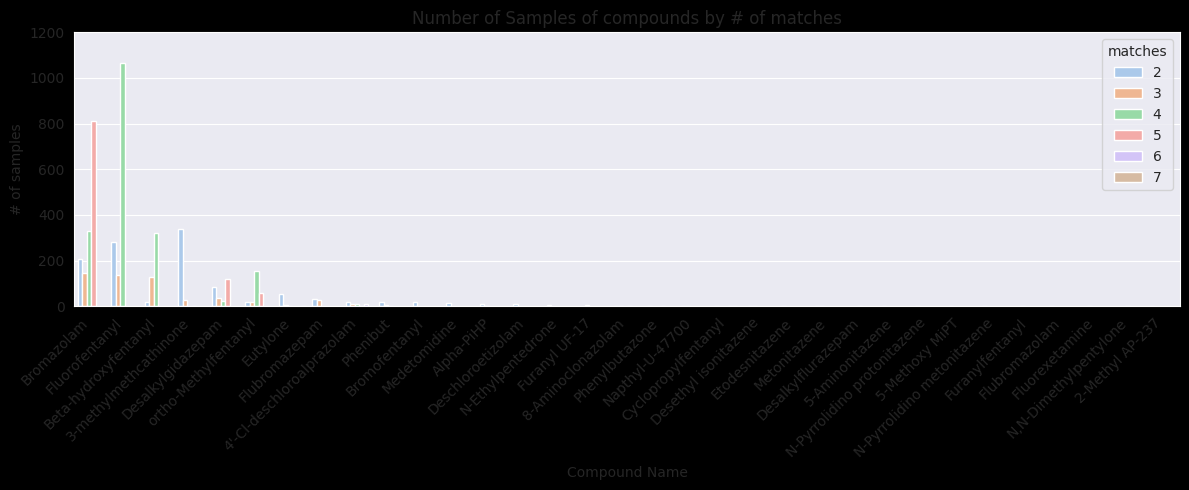

In [73]:
# Bar chart: number of fragments
plt.figure(figsize=(12, 5))
sns.set_theme(style="ticks", context="talk")
plt.style.use("dark_background")
sns.countplot(data=best2, x='Compound Name', hue='matches', order=best2['Compound Name'].value_counts(ascending=False).index, palette='pastel')
plt.title('Number of Samples of compounds by # of matches')
plt.xticks(rotation=45, ha='right')
plt.ylabel('# of samples')
plt.ylim(0, 1200)
plt.tight_layout()
plt.savefig("Figures/Compound Counts.svg", format='svg')
plt.show()

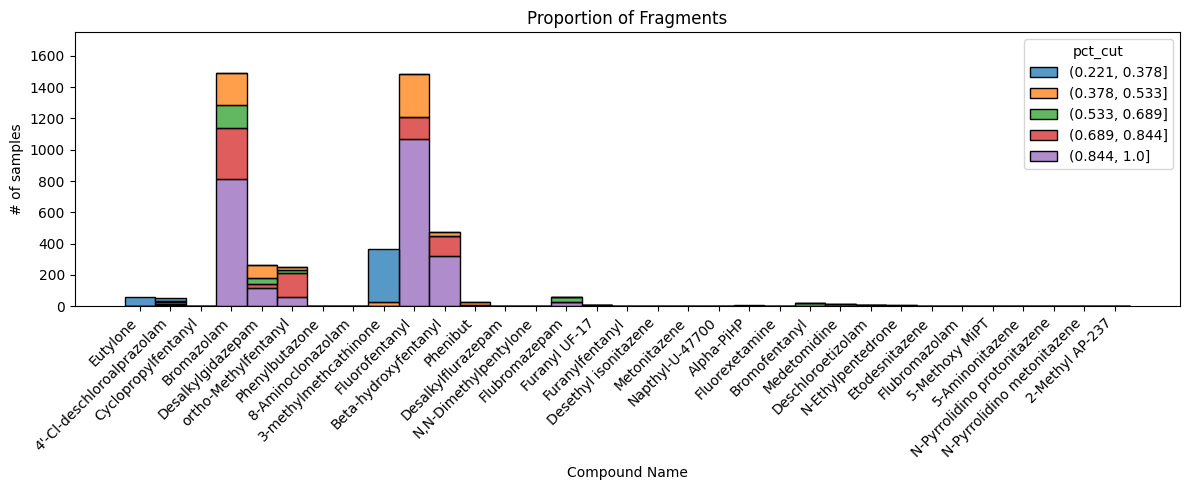

In [39]:
# Bar chart: proportion of fragments
plt.figure(figsize=(12, 5))
sns.histplot(data=best2, x='Compound Name', hue='pct_cut', multiple='stack')
plt.title('Proportion of Fragments')
plt.xticks(rotation=45, ha='right')
plt.ylabel('# of samples')
plt.ylim(0, 1750)
plt.tight_layout()
plt.savefig('Figures/proportionfragments.png')
plt.show()

In [43]:
ms2.head()

,filename,compound_name,spectrum,mz,m.z,i
0,2023-0001BG01,3-methylmethcathinone,CP5236.F1.S3548,178.12264,56.905201,4708.223633
1,2023-0001BG01,3-methylmethcathinone,CP5236.F1.S3548,178.12264,58.065968,60419.382812
2,2023-0001BG01,3-methylmethcathinone,CP5236.F1.S3548,178.12264,59.073685,8096.827148
3,2023-0001BG01,3-methylmethcathinone,CP5236.F1.S3548,178.12264,88.022354,10831.228516
4,2023-0001BG01,3-methylmethcathinone,CP5236.F1.S3548,178.12264,91.054779,67258.046875


In [45]:
databases['NPS'].head()

,Compound Name,Workflow,Associated Target Peak,MS Order,Precursor m/z,Product m/z,m/z,Height Threshold,Area Threshold,Collision Energy,Adduct,Retention Time,Retention Time Window
0,2-Fluorodeschloroketamine,TargetPeak,NaN,ms1,0,0,222.12887,0,0,0,M+H,3.84,10.0
1,2-Fluorodeschloroketamine,Fragment,1,ms2,222.12887,204.1183,222.12887,0,0,0,M+H,3.84,10.0
2,2-Fluorodeschloroketamine,Fragment,1,ms2,222.12887,191.0867,222.12887,0,0,0,M+H,3.84,10.0
3,2-Fluorodeschloroketamine,Fragment,1,ms2,222.12887,163.0918,222.12887,0,0,0,M+H,3.84,10.0
4,2-Fluorodeschloroketamine,Fragment,1,ms2,222.12887,109.0448,222.12887,0,0,0,M+H,3.84,10.0


In [42]:
best2.head()

,filename,compound_name,rt,i,intens,spectrum,matches,dbmz,Compound Name,total_fragments,ppm_err,prop_reference_ions,pct,pct_cut,rt_secs
0,2023-2213BG01,Eutylone,236.12812,236.127695,245.673444,CP2685.F1.S2959,7,236.12812,Eutylone,9,-1.801366,0.777778,78.0,"(0.689, 0.844]",14167.6872
1,2024-2266BG01,4'-Cl-deschloroalprazolam,309.09015,309.089996,366.224718,CP4600.F1.S4558,6,309.09015,4'-Cl-deschloroalprazolam,6,-0.497143,1.000000,100.0,"(0.844, 1.0]",18545.4090
2,2023-4588BG01,4'-Cl-deschloroalprazolam,309.09015,309.089539,371.941008,CP4230.F1.S4448,6,309.09015,4'-Cl-deschloroalprazolam,6,-1.978147,1.000000,100.0,"(0.844, 1.0]",18545.4090
3,2023-1175BG01,4'-Cl-deschloroalprazolam,309.09015,309.089752,381.255216,CP4485.F1.S4842,6,309.09015,4'-Cl-deschloroalprazolam,6,-1.287012,1.000000,100.0,"(0.844, 1.0]",18545.4090
4,2024-1573BG01,4'-Cl-deschloroalprazolam,309.09015,309.090179,369.809970,CP3545.F1.S4409,6,309.09015,4'-Cl-deschloroalprazolam,6,0.095258,1.000000,100.0,"(0.844, 1.0]",18545.4090


/tmp/ipykernel_1567299/3605917918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best2['rt_secs'] = 60*best2['db_rt']


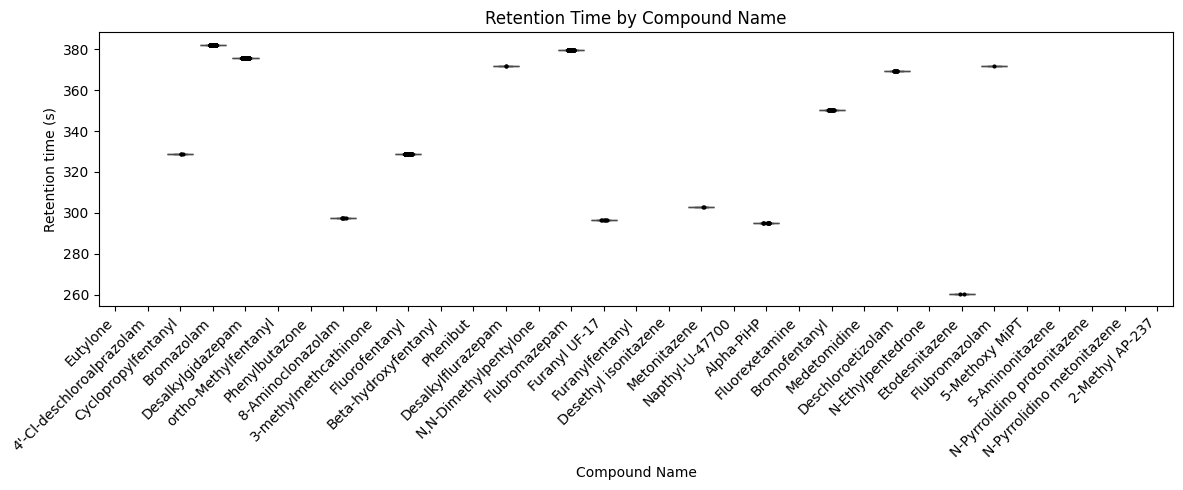

In [50]:
best2['rt_secs'] = 60*best2['db_rt']
# Boxplot: retention times
plt.figure(figsize=(12, 5))
sns.boxplot(data=best2, x='Compound Name', y='rt_secs', color='grey', fliersize=0)
sns.stripplot(data=best2, x='Compound Name', y='rt_secs', color='black', size=3, jitter=True)
plt.title('Retention Time by Compound Name')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Retention time (s)')
plt.tight_layout()
plt.savefig('Figures/retention_times.png')
plt.show()

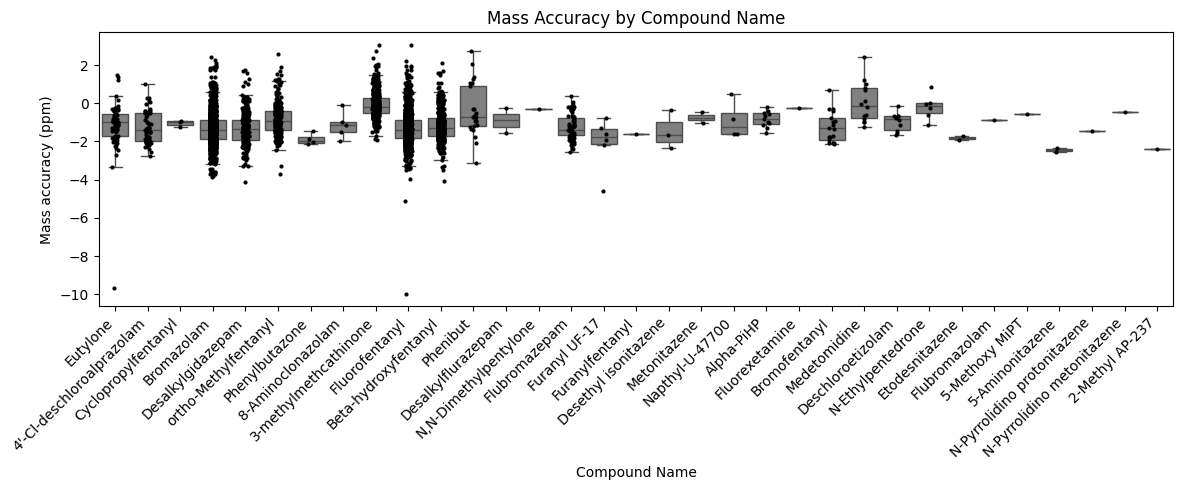

In [51]:
# Boxplot: mass accuracy
plt.figure(figsize=(12, 5))
sns.boxplot(data=best2, x='Compound Name', y='ppm_err', color='grey', fliersize=0)
sns.stripplot(data=best2, x='Compound Name', y='ppm_err', color='black', size=3, jitter=True)
plt.title('Mass Accuracy by Compound Name')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mass accuracy (ppm)')
plt.tight_layout()
plt.savefig('Figures/mass_accuracy.png')
plt.show()

In [ ]:









# Save the combined figure
plt.savefig("figure2-revised.pdf", format='pdf', bbox_inches='tight')